<font size="6">Main script to call functions from other scripts</font> 

#  Import libraries

In [12]:
# data manipulations
import numpy as np
import pandas as pd

# pypark
from pyspark.ml import PipelineModel  # to load the pipeline
from threading import Thread
from pyspark.streaming import StreamingContext

# evaluation statistics
from sklearn.metrics import confusion_matrix

# performance evaluation
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

# visualize
import matplotlib.pyplot as plt

# own functions
from functions.performance.metrics import plot_confusion_matrix 

In [2]:
# when you change somehting in your own library (e.g. plot_confusion_matrix) it's automatically updated, you don't need to reimport
%load_ext autoreload
%autoreload 2

# Global variables

In [3]:
# avaialble plotting styles
print(plt.style.available)
plt.style.use('bmh')

# global variables in CAPITAL letters
PATH_LOAD_MODEL = "../output/models/logistic_regression"
SAVE_PREDICTIONS = True # save predictions
PATH_SAVE_PREDICTIONS = "../../output/predictions/logistic_regression.parquet" # where to save the predictions
VERBOSE = True # print intermediate output

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test', '_classic_test_patch']


# Get streaming instances

In [4]:
class StreamingThread(Thread):
    def __init__(self, ssc):
        Thread.__init__(self)
        self.ssc = ssc
    # Start stream
    def run(self):
        ssc.start()
        ssc.awaitTermination()
    # Stop stream
    def stop(self):
        print('----- Stopping... this may take a few seconds -----')
        self.ssc.stop(stopSparkContext=False, stopGraceFully=True)

#  Load Pipeline 1

This pipeline cleans the data and get the data in the right format

**TODO**

```python
instead of calling  %run "pipeline1.ipynb"  
make a proper libary so we can call from functions.data_cleaning import pipeline1
```
for an example see 

```python 
from functions.performance.metrics import plot_confusion_matrix  
```
this is also a self defined library

**Why?** now we have to uncomment code,  because we want to reuse the code in other notebooks,
leaving it like this seems bit clumpsy

In [5]:
# Initialize other notebooks
%run "pipeline1.ipynb"

# Load Pipeline 2

feature engineering steps and final prediction model

In [6]:
pipeline2 = PipelineModel.load(PATH_LOAD_MODEL)

#  Full pipeline

In [7]:
def final_pipeline(time, rdd, save_predictions=SAVE_PREDICTIONS, path=PATH_SAVE_PREDICTIONS, verbose=VERBOSE):
    """""" """
    This function will serve as the construction pipeline.
    Here all preprocessing functions need to be called and 
    need to be able to handle one wiki edit.
    """ """"""
    if rdd.isEmpty():
        return
    if verbose:
        print("========= %s =========" % str(time))

    # -------------------------------------------------------------------------
    # 1) Pipeline 1: Mostly data cleaning and getting data in the right shape
    # -------------------------------------------------------------------------
    df = spark.read.json(rdd)
    clean_df = get_clean_df(df)
    df_with_difference = get_difference_column(clean_df)
    final_df = split_difference_into_removed_added(df_with_difference)
    
    print(f"Result after pipeline 1:")
    if verbose:
        final_df.show(2)
        
    # ------------------------------------------------------------------------
    # 2) Pipeline 2: Feature engineering, and Predicting
    # ------------------------------------------------------------------------
    predictions = pipeline2.transform(final_df)
    print("Result after pipeline 2 (predictions):")
    if verbose:
        predictions.select(['target', 'label', 'prediction','probability']).show(2)
    # save predictions
    if save_predictions: 
        print(f"saving predictions of batch in: {path}")
        predictions.write.mode("append").save(path)
        

# Begin online stream and make prediction per wiki edit

In [8]:
ssc = StreamingContext(sc, 10) # Get minibatches every 10 seconds

In [9]:
lines = ssc.socketTextStream("seppe.net", 7778)
lines.foreachRDD(final_pipeline)

In [10]:
ssc_t = StreamingThread(ssc)
ssc_t.start()

========= 2020-05-28 20:15:40 =========
Result after pipeline 1:
+------+--------------------+-------------+----------+--------------------+--------------------+-------------+--------------------+
| label|             comment|   title_page| name_user|      clean_old_text|      clean_new_text|removed_words|         added_words|
+------+--------------------+-------------+----------+--------------------+--------------------+-------------+--------------------+
|unsafe|undid revision 95...|wearside jack|martintype|use british engli...|use british engli...|      [y, , ]|                 [i]|
|  safe|       double spaces|castine maine|     kidad|infobox settlemen...|infobox settlemen...|      [empty]|[, united, states...|
+------+--------------------+-------------+----------+--------------------+--------------------+-------------+--------------------+
only showing top 2 rows

Result after pipeline 2 (predictions):
+------+------+----------+--------------------+
|target| label|prediction|     

In [11]:
ssc_t.stop()

----- Stopping... this may take a few seconds -----
Result after pipeline 1:
+-----+--------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|  title_page|   name_user|      clean_old_text|      clean_new_text|       removed_words|         added_words|
+-----+--------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+
| safe|original the majo...|nuclear gene|      cs0218|a '''nuclear gene...|a '''nuclear gene...|[the, majority, o...|[the, majority, o...|
| safe| other charted songs|    txt band|rockysmile11|short description...|short description...|             [empty]|             [empty]|
+-----+--------------------+------------+------------+--------------------+--------------------+--------------------+--------------------+
only showing top 2 rows

Result after pipeline 2 (predictions):
+------+-----+----------+

# Check how we performed on the live data

**useful resources:**
 - https://runawayhorse001.github.io/LearningApacheSpark/classification.html

**TODO**
- look at other scoring metrics for imbalanced data:
    - e.g. Matthews correlation coefficient (MCC)  ==> I think this is one of the best metrics for imbalanced data
    - Cohen's kappa statistic
    - F1 score
    - ...

In [12]:
# load predictions from live data
predictions_live = spark.read.parquet(PATH_SAVE_PREDICTIONS)
predictions_live.select(['label','target','prediction']).show(5)

+------+------+----------+
| label|target|prediction|
+------+------+----------+
|  safe|   0.0|       0.0|
|  safe|   0.0|       0.0|
|  safe|   1.0|       2.0|
|  safe|   0.0|       1.0|
|unsafe|   1.0|       1.0|
+------+------+----------+
only showing top 5 rows



## This is used for decoding the numeric predictions values back to the original labels

In [13]:
label_str = list(predictions_live.select("label").toPandas()['label'].unique())
label_num = [0,1,2]
map_num_2_str = dictionary = dict(zip(label_num, label_str))
print(map_num_2_str)

{0: 'safe', 1: 'unsafe', 2: 'vandal'}


## A) Confusion Matrix

In [14]:
class_names = label_str
y_true = predictions_live.select("label").toPandas()
y_pred = predictions_live.select("prediction").toPandas()
y_pred = y_pred['prediction'].map(map_num_2_str, na_action='ignore')

# make confusion matrix
cnf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=class_names)
pd.DataFrame(cnf_matrix, columns=class_names, index=class_names)

,safe,unsafe,vandal
safe,137,101,3
unsafe,12,14,0
vandal,4,0,0


Confusion matrix, without normalization
        safe  unsafe  vandal
safe     137     101       3
unsafe    12      14       0
vandal     4       0       0


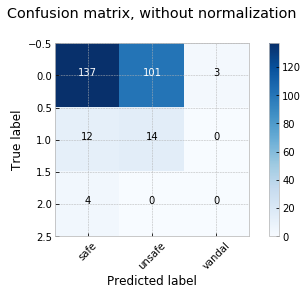

In [17]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='Confusion matrix, without normalization')

# I need to fix this manually, we should fix this in the future (this look bit clumpsy)
#plt.yticks([2.5,2,1.5,1,0.5,0,-.5], labels=["",label_str[2],"",label_str[1],"",label_str[0]]);

## 8.2 Summary metrics

**TODO**
- look at other scoring metrics for imbalanced data:
    - e.g. Matthews correlation coefficient (MCC)  ==> I think this is one of the best metrics for imbalanced data
    - Cohen's kappa statistic
    - F1 score
    - ...

In [18]:
# F1 score
evaluator = MulticlassClassificationEvaluator(
    predictionCol="prediction", labelCol='target', metricName="f1")
print(f"F1 score: {round(evaluator.evaluate(predictions_live), 4)}")

F1 score: 0.5228


In [9]:
# mcc and kappa
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

print(f" MCC: {mcc}")
print(f" Kappa: {kappa}")

 MCC: 0.033243370938571194
 Kappa: 0.022152223781970126


In [10]:
# AUC
results = predictions_live.select(['probability', 'target'])
# prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)

metrics = metric(scoreAndLabels)
print("Area under ROC score is : ", round(metrics.areaUnderROC,4))

Area under ROC score is :  0.5722
